<a href="https://colab.research.google.com/github/SanthiyaBaskar/NutriClass-Food-Classification/blob/main/Assgn_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install xgboost imbalanced-learn

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from google.colab import files

uploaded = files.upload()  # upload synthetic_food_dataset_imbalanced.csv
CSV_NAME = '/content/synthetic_food_dataset_imbalanced.csv'  # change if your file name differs
df = pd.read_csv(CSV_NAME)
print(df.shape); display(df.head()); df.info()


Saving synthetic_food_dataset_imbalanced.csv to synthetic_food_dataset_imbalanced (1).csv
(31700, 16)


,Calories,Protein,Fat,Carbs,Sugar,Fiber,Sodium,Cholesterol,Glycemic_Index,Water_Content,Serving_Size,Meal_Type,Preparation_Method,Is_Vegan,Is_Gluten_Free,Food_Name
0,290.463673,14.340084,14.152608,35.266644,4.828030,1.291432,647.553389,24.990309,81.575896,45.669118,197.570043,dinner,fried,False,False,Pizza
1,212.626748,4.080908,11.621584,23.218957,16.347814,0.130303,68.572414,34.301652,69.522492,49.854415,103.833510,snack,raw,False,True,Ice Cream
2,330.695408,14.326708,19.747680,29.479164,6.251137,0.794477,663.171859,34.816834,62.552384,40.132866,198.989367,snack,raw,False,False,Burger
3,198.070798,9.452445,5.475896,32.097878,2.984621,1.710468,300.749543,28.510998,68.688853,57.423461,135.714202,lunch,fried,False,True,Sushi
4,274.496228,6.099547,16.256002,29.756638,17.352958,1.465676,296.314958,15.403173,70.385059,33.170460,73.019474,snack,baked,False,False,Donut


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31700 entries, 0 to 31699
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Calories            31325 non-null  float64
 1   Protein             31325 non-null  float64
 2   Fat                 31325 non-null  float64
 3   Carbs               31325 non-null  float64
 4   Sugar               31325 non-null  float64
 5   Fiber               31325 non-null  float64
 6   Sodium              31325 non-null  float64
 7   Cholesterol         31325 non-null  float64
 8   Glycemic_Index      31325 non-null  float64
 9   Water_Content       31325 non-null  float64
 10  Serving_Size        31325 non-null  float64
 11  Meal_Type           31700 non-null  object 
 12  Preparation_Method  31700 non-null  object 
 13  Is_Vegan            31700 non-null  bool   
 14  Is_Gluten_Free      31700 non-null  bool   
 15  Food_Name           31700 non-null  object 
dtypes: b

In [ ]:
# Try common target names
candidates = ['Food_Category','food_category','Category','Label','class','Class']
target = None
for c in candidates:
    if c in df.columns:
        target = c; break

# If still not found, pick a likely categorical column with small unique count
if target is None:
    cat_like = [c for c in df.columns if (df[c].dtype=='object' or df[c].nunique()<=50)]
    if len(cat_like)==0:
        raise ValueError("Target column not found. Inspect df.columns and set `target` manually.")
    target = cat_like[-1]

print("Using target column:", target)

# Basic sanity
print("Missing values per column:\n", df.isna().sum())
print("\nClass distribution:\n", df[target].value_counts())


Using target column: Food_Name
Missing values per column:
 Calories              375
Protein               375
Fat                   375
Carbs                 375
Sugar                 375
Fiber                 375
Sodium                375
Cholesterol           375
Glycemic_Index        375
Water_Content         375
Serving_Size          375
Meal_Type               0
Preparation_Method      0
Is_Vegan                0
Is_Gluten_Free          0
Food_Name               0
dtype: int64

Class distribution:
 Food_Name
Pizza        6000
Burger       5000
Donut        4500
Pasta        4000
Sushi        3500
Ice Cream    3000
Steak        2000
Apple        1500
Banana       1200
Salad        1000
Name: count, dtype: int64


In [ ]:
df = df.drop_duplicates().copy()

# Fill numeric NaNs with median
num_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical NaNs with mode
cat_cols = [c for c in df.columns if c not in num_cols]
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode().iloc[0])

# IQR capping for outliers on numeric columns
for col in num_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lo, hi = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df[col] = np.clip(df[col], lo, hi)

print("After cleaning:", df.shape)


After cleaning: (31387, 16)


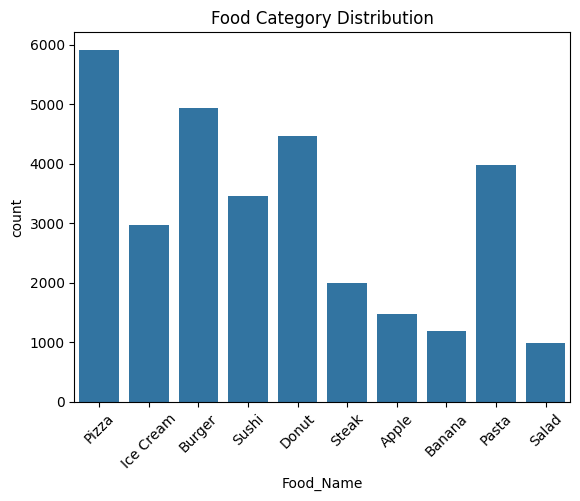

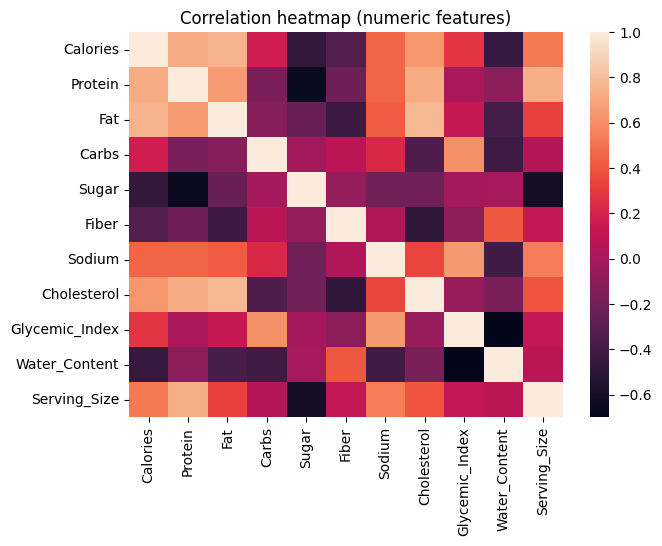

In [ ]:
sns.countplot(x=target, data=df)
plt.title("Food Category Distribution"); plt.xticks(rotation=45); plt.show()

corr = df[num_cols].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=False)
plt.title("Correlation heatmap (numeric features)")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop(columns=[target])
# Keep only numeric predictors (drop names/strings)
X = X.select_dtypes(include=np.number)
y = df[target].astype(str)

labeler = LabelEncoder()
y_enc = labeler.fit_transform(y)
class_names = labeler.classes_
n_classes = len(class_names)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

X.shape, n_classes, class_names[:10]


((31387, 11),
 10,
 array(['Apple', 'Banana', 'Burger', 'Donut', 'Ice Cream', 'Pasta',
        'Pizza', 'Salad', 'Steak', 'Sushi'], dtype=object))

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

RANDOM_STATE = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def pipe(model):
    # Scale → SMOTE (applies only on fit) → Model
    return ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('model', model)
    ])

models = {
    "Logistic Regression": pipe(LogisticRegression(max_iter=2000, class_weight='balanced')),
    "KNN":                 pipe(KNeighborsClassifier()),
    "SVM":                 pipe(SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE)),
    "Decision Tree":       pipe(DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)),
    "Random Forest":       pipe(RandomForestClassifier(class_weight='balanced', n_estimators=300, random_state=RANDOM_STATE)),
    "Gradient Boosting":   pipe(GradientBoostingClassifier(random_state=RANDOM_STATE)),
    "XGBoost":             pipe(XGBClassifier(
                                objective='multi:softprob',
                                num_class=n_classes,
                                eval_metric='mlogloss',
                                n_estimators=400,
                                learning_rate=0.1,
                                max_depth=6,
                                subsample=0.9,
                                colsample_bytree=0.9,
                                tree_method='hist',
                                random_state=RANDOM_STATE))
}

results = []
for name, mdl in models.items():
    # 5-fold macro F1 on training set (CV)
    cv_f1 = cross_val_score(mdl, X_train, y_train, cv=cv, scoring='f1_macro').mean()
    # Fit on full train, evaluate on held-out test
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)
    acc  = accuracy_score(y_test, preds)
    f1m  = f1_score(y_test, preds, average='macro')
    prec = precision_score(y_test, preds, average='macro', zero_division=0)
    rec  = recall_score(y_test, preds, average='macro')
    results.append([name, acc, f1m, prec, rec, cv_f1])

import pandas as pd
res_df = pd.DataFrame(results, columns=["Model","Test_Accuracy","Test_MacroF1","Test_MacroPrecision","Test_MacroRecall","CV_MacroF1"]).sort_values(["Test_MacroF1","Test_Accuracy"], ascending=False)
res_df


,Model,Test_Accuracy,Test_MacroF1,Test_MacroPrecision,Test_MacroRecall,CV_MacroF1
1,KNN,0.991558,0.992263,0.992865,0.991752,0.988750
2,SVM,0.993469,0.989646,0.986016,0.993805,0.987040
6,XGBoost,0.993310,0.989224,0.985674,0.993319,0.986823
4,Random Forest,0.992673,0.988899,0.985328,0.993015,0.986806
5,Gradient Boosting,0.992832,0.988511,0.984878,0.992698,0.986361
0,Logistic Regression,0.989965,0.986663,0.985956,0.987521,0.986100
3,Decision Tree,0.986620,0.983788,0.980223,0.987948,0.981315


Best model: KNN
                 Model  Test_Accuracy  Test_MacroF1  Test_MacroPrecision  \
1                  KNN       0.991558      0.992263             0.992865   
2                  SVM       0.993469      0.989646             0.986016   
6              XGBoost       0.993310      0.989224             0.985674   
4        Random Forest       0.992673      0.988899             0.985328   
5    Gradient Boosting       0.992832      0.988511             0.984878   
0  Logistic Regression       0.989965      0.986663             0.985956   
3        Decision Tree       0.986620      0.983788             0.980223   

   Test_MacroRecall  CV_MacroF1  
1          0.991752    0.988750  
2          0.993805    0.987040  
6          0.993319    0.986823  
4          0.993015    0.986806  
5          0.992698    0.986361  
0          0.987521    0.986100  
3          0.987948    0.981315  

Classification report for: KNN
              precision    recall  f1-score   support

       Apple    

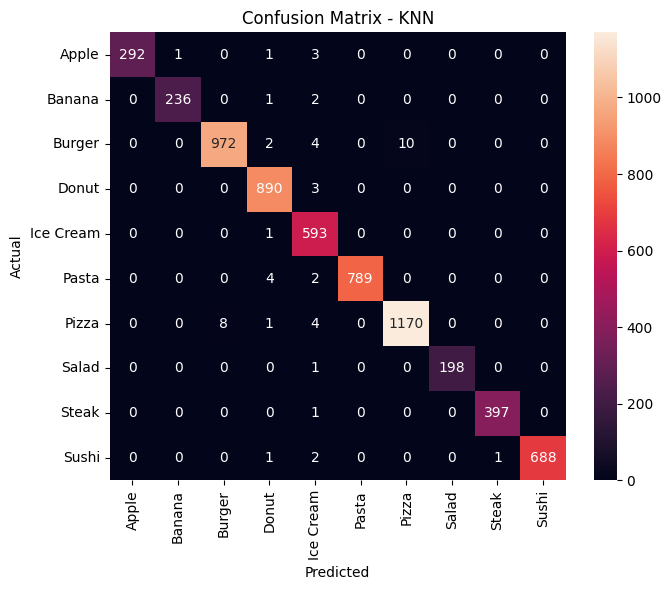

In [ ]:
best_row = res_df.iloc[0]
best_name = best_row["Model"]
best_model = models[best_name]
print("Best model:", best_name)
print(res_df)

# Detailed report
pred_best = best_model.predict(X_test)
print("\nClassification report for:", best_name)
print(classification_report(y_test, pred_best, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, pred_best)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix - {best_name}")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()


In [ ]:
mdl_core = best_model.named_steps['model']
if hasattr(mdl_core, "feature_importances_"):
    importances = mdl_core.feature_importances_
    imp = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(15)
    imp.plot(kind='bar'); plt.title(f"Top features - {best_name}"); plt.tight_layout(); plt.show()
else:
    print("Feature importances not available for", best_name)


Feature importances not available for KNN


In [ ]:
import joblib, json
joblib.dump(best_model, "best_model.pkl")
with open("label_classes.json","w") as f:
    json.dump(list(class_names), f)
print("Saved: best_model.pkl, label_classes.json")


Saved: best_model.pkl, label_classes.json


In [ ]:
req = """pandas
numpy
scikit-learn
matplotlib
seaborn
xgboost
imbalanced-learn
joblib
"""
with open("requirements.txt","w") as f: f.write(req)
print("Wrote requirements.txt")


Wrote requirements.txt


In [ ]:
!pip install streamlit pyngrok --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 99.7 MB/s eta 0:00:00


In [ ]:
!ngrok config add-authtoken 33mUwH6JrxjCI9fa8zlqco7vY0o_2YxgjyRezZsSwvdpcKQos


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print(public_url)
!streamlit run app.py


NgrokTunnel: "https://reduced-squashier-doris.ngrok-free.dev" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.227.204:8501

2025-10-13 13:12:23.384 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.


In [11]:
from google.colab import files
uploaded = files.upload()


Saving best_model.pkl to best_model.pkl
Saving label_classes.json to label_classes.json


In [12]:
from google.colab import files
uploaded = files.upload()


Saving synthetic_food_dataset_imbalanced.csv to synthetic_food_dataset_imbalanced.csv


In [15]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib, json, os, random

# -------------- PAGE CONFIG ----------------
st.set_page_config(page_title="🍎 NutriClass Predictor", page_icon="🍎", layout="wide")

st.title("🍎 NutriClass – Nutrition ➡️ Food Category")
st.markdown(
    "A smart ML tool to classify food categories based on nutritional values like **Calories**, "
    "**Protein**, **Carbs**, **Fat**, and **Sugar**."
)

# -------------- FILE CHECKS ----------------
model_file = "best_model.pkl"
labels_file = "label_classes.json"
csv_file = "synthetic_food_dataset_imbalanced.csv"

if not os.path.exists(model_file) or not os.path.exists(labels_file):
    st.error("❌ Model or Label files not found. Please upload `best_model.pkl` and `label_classes.json`.")
    st.stop()

model = joblib.load(model_file)
label_classes = json.load(open(labels_file))

if not os.path.exists(csv_file):
    st.error(f"❌ CSV file `{csv_file}` not found. Please upload it.")
    st.stop()

df = pd.read_csv(csv_file)

# ✅ Auto-detect target column
target_col = None
for col in df.columns:
    if col.strip().lower() in ["food_category", "food category", "category", "label"]:
        target_col = col
        break
if target_col is None:
    target_col = df.columns[-1]

# -------------- DATA TABLE ----------------
st.subheader("📊 Full Dataset Preview")
st.caption(f"Showing first 500 rows out of {len(df)} total records")
st.dataframe(df.head(500), width='stretch', height=400)

# -------------- CATEGORY SEARCH -----------
st.subheader("🔍 Search Food by Category")
if target_col in df.columns:
    categories = sorted(df[target_col].unique())
    selected_cat = st.selectbox("Choose a category to filter:", ["-- Select --"] + list(categories))

    if selected_cat != "-- Select --":
        filtered = df[df[target_col] == selected_cat].head(50)
        st.dataframe(filtered, width='stretch', height=300)
else:
    st.warning("⚠️ No target column detected for category search.")

# -------------- LIVE PREDICTOR ------------
st.subheader("🧮 Live Nutritional Predictor")
num_cols = df.select_dtypes(include=np.number).columns.tolist()
inputs = {}

col1, col2 = st.columns(2)
for i, col_name in enumerate(num_cols):
    with (col1 if i % 2 == 0 else col2):
        inputs[col_name] = st.number_input(
            f"{col_name}",
            value=float(df[col_name].median()),
            step=0.1
        )

if st.button("🚀 Predict Food Category"):
    xdf = pd.DataFrame([inputs])
    pred = model.predict(xdf)[0]
    st.success(f"🍽 Predicted Category: **{label_classes[pred]}**")

# -------------- RANDOM SAMPLE ------------
st.subheader("🎲 Try a Random Data Row")
if st.button("Pick Random Row & Predict"):
    idx = random.randint(0, len(df)-1)
    sample = df.iloc[idx]
    x = sample[num_cols].to_frame().T
    pred = model.predict(x)[0]
    predicted_label = label_classes[pred]

    st.write("**🔹 Random Row Nutritional Values:**")
    st.dataframe(x, width='stretch')
    st.success(f"🍽 Model Prediction: **{predicted_label}**  |  Actual: **{sample[target_col]}**")


Writing app.py


In [2]:
!pip install streamlit pyngrok --quiet
!ngrok config add-authtoken 33mUwH6JrxjCI9fa8zlqco7vY0o_2YxgjyRezZsSwvdpcKQos


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.8 MB/s eta 0:00:00
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [3]:
!nohup streamlit run app.py --server.port 8501 &>/content/logs.txt &



In [14]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print("🌐 Public URL:", public_url)


🌐 Public URL: NgrokTunnel: "https://reduced-squashier-doris.ngrok-free.dev" -> "http://localhost:8501"


In [4]:
!tail -n 50 /content/logs.txt


Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py


In [5]:
!pip install streamlit pyngrok --upgrade --quiet


In [6]:
!which streamlit


/usr/local/bin/streamlit


In [7]:
!nohup /usr/local/bin/streamlit run app.py --server.port 8501 &>/content/logs/streamlit.log &


/bin/bash: line 1: /content/logs/streamlit.log: No such file or directory


In [8]:
!pip install streamlit pyngrok --quiet


In [9]:
!ngrok config add-authtoken 33mUwH6JrxjCI9fa8zlqco7vY0o_2YxgjyRezZsSwvdpcKQos


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [17]:
import threading
import time
from pyngrok import ngrok

# Start Streamlit in a separate thread
def run_streamlit():
    !streamlit run app.py --server.port 8501

thread = threading.Thread(target=run_streamlit, daemon=True)
thread.start()

# Wait a bit for it to boot
time.sleep(5)

# Create tunnel
public_url = ngrok.connect(8501)
print("🌍 Public URL:", public_url)




2025-10-14 12:11:53.085 Port 8501 is already in use
🌍 Public URL: NgrokTunnel: "https://reduced-squashier-doris.ngrok-free.dev" -> "http://localhost:8501"
